In [1]:
from kernelforge._fchl19 import flocal_kernel, generate_fchl_acsf, generate_fchl_acsf_and_gradients, flocal_kernel_symm, fatomic_local_gradient_kernel, fgdml_kernel
from kernelforge._kernels import solve_cholesky
# import kernelforge
# help(kernelforge._fchl19)
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm

In [2]:
import os
print(os.environ["LD_PRELOAD"])

/home/andersx/dev/laptop-qml/libfakeintel.so


In [31]:
train = np.load("/home/andersx/dev/laptop-qml/kitchen-sink-qml/data/ethanol_ccsd_t-train.npz")
test = np.load("/home/andersx/dev/laptop-qml/kitchen-sink-qml/data/ethanol_ccsd_t-test.npz")
elements=[1, 6, 8]
n_train = 200
n_test = 999

In [32]:
X = np.asarray([generate_fchl_acsf(r, train["z"], elements=elements) for r in tqdm(train["R"][:n_train])])
dX = np.asarray([generate_fchl_acsf_and_gradients(r, train["z"], elements=elements)[1] for r in tqdm(train["R"][:n_train])])
Q = np.asarray([train["z"] for r in train["R"][:n_train]])
N = np.asarray([len(train["z"]) for r in train["R"][:n_train]])

Yf = train["F"][:n_train].flatten()
print(Yf)
Yscal = np.std(Yf)
Yf /= Yscal
# Yf = -Yf
Y = train["E"][:n_train].flatten()
offset = np.mean(train["E"])
Y -= offset

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

[-10.20301055  33.65634891  -1.91316347 ...   1.70609665  22.80192018
  26.694466  ]


In [25]:
print(offset)

-97084.70075622278


In [26]:
Xt = np.asarray([generate_fchl_acsf(r, test["z"], elements=elements) for r in tqdm(test["R"][:n_test])])
dXt = np.asarray([generate_fchl_acsf_and_gradients(r, test["z"], elements=elements)[1] for r in tqdm(test["R"][:n_test])])
Qt = np.asarray([test["z"] for r in test["R"][:n_test]])
Nt = np.asarray([len(test["z"]) for r in test["R"][:n_test]])

Yft = test["F"][:n_test].flatten()
# Yft /= Yscal

Yt = test["E"].flatten()[:n_test] - offset

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

In [38]:
sigma = 2
t0 = time.perf_counter()
# K = flocal_kernel_symm(X, Q, N, sigma)
H = fgdml_kernel(X, X, dX, dX, Q, Q, N, N, sigma)
t1 = time.perf_counter()
print(H.shape)
print(t1-t0)

(5400, 5400)
2.0464500969974324


In [39]:
H[100:105, 100:105]

array([[ 5.05645196,  1.95662023,  1.2175009 ,  0.81780798, -5.76539616],
       [ 1.95662023,  0.90815627,  0.37595755,  0.11880575, -2.34438498],
       [ 1.2175009 ,  0.37595755,  0.52482626,  0.34141588, -1.2905715 ],
       [ 0.81780798,  0.11880575,  0.34141588,  0.42101143, -0.82812367],
       [-5.76539616, -2.34438498, -1.2905715 , -0.82812367,  6.92341681]])

In [40]:
H[100:105, 100:105]

array([[ 5.05645196,  1.95662023,  1.2175009 ,  0.81780798, -5.76539616],
       [ 1.95662023,  0.90815627,  0.37595755,  0.11880575, -2.34438498],
       [ 1.2175009 ,  0.37595755,  0.52482626,  0.34141588, -1.2905715 ],
       [ 0.81780798,  0.11880575,  0.34141588,  0.42101143, -0.82812367],
       [-5.76539616, -2.34438498, -1.2905715 , -0.82812367,  6.92341681]])

In [41]:
H[:5, :5]

array([[ 2.3618658 ,  0.73907773,  0.09922488, -1.58487104, -1.12328016],
       [ 0.73907773,  8.85184232,  0.25368039, -4.30059223, -3.93191058],
       [ 0.09922488,  0.25368039,  0.05012864, -0.19495232, -0.178615  ],
       [-1.58487104, -4.30059223, -0.19495232,  4.06736096,  3.02705644],
       [-1.12328016, -3.93191058, -0.178615  ,  3.02705644,  3.03767997]])

In [42]:
K_solve = H.copy()
for i in range(K_solve.shape[0]):
    K_solve[i,i] += 1e-10
alphas = solve_cholesky(K_solve, Yf)
alphas

array([ -7011.65863807, -17897.34369297, -16113.76786514, ...,
           68.33478781,  33669.5677037 ,   2509.54160245], shape=(5400,))

In [43]:
t0 = time.perf_counter()
Kp = fatomic_local_gradient_kernel(Xt, X, dX, Qt, Q, Nt, N, sigma)
print(Kp.shape)
t1 = time.perf_counter()
print(t1-t0)

(999, 5400)
3.069288682017941


In [44]:
Yp = Kp @ alphas * Yscal
Yp -= np.mean(Yp)

RMSE = 0.199126300609521
PearsonRResult(statistic=np.float64(0.999743078735741), pvalue=np.float64(0.0))


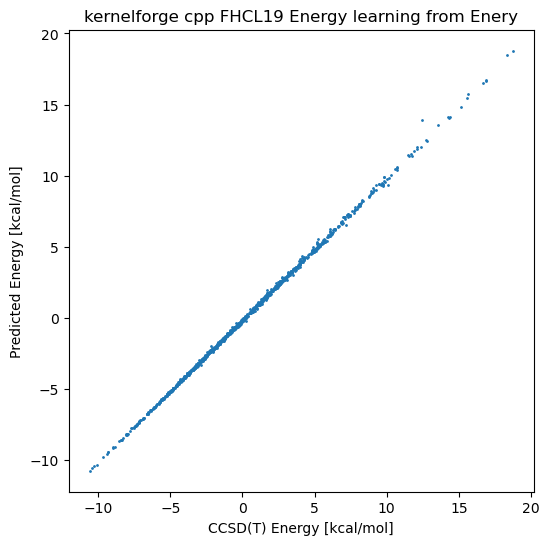

In [45]:
rmse = np.sqrt(np.mean(np.square(Yt - Yp)))
res = pearsonr(Yp, Yt)
print(f"RMSE = {rmse}")
print(res)
fig = plt.figure(figsize=(6,6))
plt.xlabel("CCSD(T) Energy [kcal/mol]")
plt.ylabel("Predicted Energy [kcal/mol]")
plt.title("kernelforge cpp FHCL19 Energy learning from Enery")
plt.scatter(Yt, Yp, s=1)

In [46]:
t0 = time.perf_counter()
Ht = fgdml_kernel(Xt, X, dXt, dX, Qt, Q, Nt, N, sigma).T
t1 = time.perf_counter()
print(Ht.shape)
print(t1-t0)

(26973, 5400)
10.142247198004043


In [47]:
Yfp = Ht @ alphas * Yscal
Yfp.shape

(26973,)

RMSE = 0.6900930465703387
PearsonRResult(statistic=np.float64(0.9996843756612648), pvalue=np.float64(0.0))


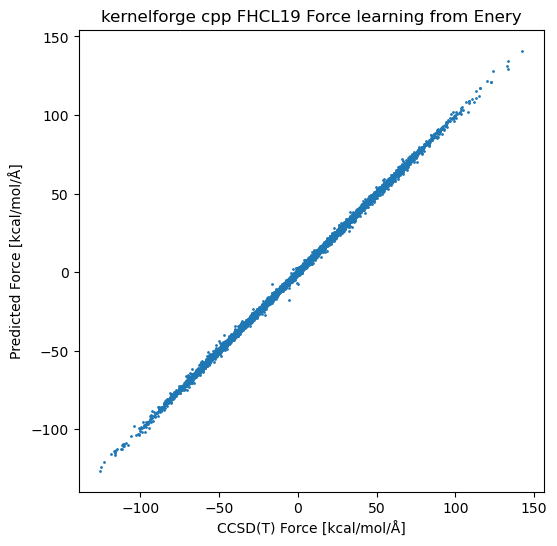

In [48]:
rmse = np.sqrt(np.mean(np.square(Yft - Yfp)))
res = pearsonr(Yfp, Yft)
print(f"RMSE = {rmse}")
print(res)
fig = plt.figure(figsize=(6,6))
plt.xlabel("CCSD(T) Force [kcal/mol/Å]")
plt.ylabel("Predicted Force [kcal/mol/Å]")
plt.title("kernelforge cpp FHCL19 Force learning from Enery")
plt.scatter(Yft, Yfp, s=1)